In [2]:
from pandas_datareader import data as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

from   scipy.io import loadmat
import time
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

from sklearn.model_selection import StratifiedKFold, cross_val_score  # 导入交叉检验算法
from sklearn.feature_selection import SelectPercentile, f_classif  # 导入特征选择方法库
from sklearn.pipeline import Pipeline  # 导入Pipeline库
from sklearn.metrics import accuracy_score  # 准确率指标
from sklearn.metrics import roc_auc_score
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

# from utility_funcs import *

import warnings
warnings.filterwarnings('ignore')


In [3]:
pre_neutralized_factors = pd.read_pickle('/home/ubuntu/data/factors.pkl')
neutralized_factors = pd.read_pickle('/home/ubuntu/data/neutralized_factors.pkl')
selected_factors = pd.read_pickle('/home/ubuntu/data/selected_factors.pkl')

feature_list = list(selected_factors.index)

print('Finish loading!')

Finish loading!


In [4]:
data = neutralized_factors[['code','day','sector','weekly_return'] + feature_list]
data

,code,day,sector,weekly_return,VOL60,VOL20,VOL5,VOL10,VOL120,ACD6,...,CFO2EV,TVSTD6,Volatility,JDQS20,DDNCR,TVMA20,MoneyFlow20,CTOP,HSIGMA,CCI5
0,4,20180105.0,28,-4.024702,-0.775176,-0.917950,-1.061420,-1.222159,-1.161016,0.764560,...,0.783831,-0.287749,-0.126651,1.940750,-0.199333,-0.268916,-0.268563,-0.397089,-0.441407,0.090599
1,600601,20180105.0,28,-1.355046,-1.246389,-1.201163,-1.220196,-1.228082,-1.201746,-0.507241,...,0.799740,-1.281351,-0.046834,-1.782799,0.605341,-1.400236,-1.399994,-0.217249,-1.758799,0.140573
2,600652,20180105.0,29,13.520729,-0.744055,-0.683546,-0.724665,-0.672548,-0.431911,-0.313788,...,0.002389,-0.900940,-0.865201,-0.269848,-0.297214,-0.631245,-0.631016,0.053134,0.010386,0.663940
3,600602,20180105.0,28,-0.277466,-1.286696,-1.117314,-1.102816,-1.186759,-1.254980,0.030110,...,0.503842,-0.909087,0.451541,-0.265318,-1.361486,-1.121716,-1.121395,0.481633,-0.360316,0.511521
4,600651,20180105.0,16,1.354170,0.663059,0.009371,-0.151267,0.070555,0.069727,0.066070,...,-0.361441,-0.680234,-1.052387,-0.905105,0.814633,-0.344706,-0.345137,0.192816,0.109807,0.292743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573404,300980,20211022.0,6,1.013339,0.478774,-0.493997,-0.906647,-0.926890,1.402471,-0.310812,...,-0.154294,0.435118,1.179695,1.747348,1.026139,0.563466,0.563503,-0.636685,-1.164114,0.013526
573405,605016,20211022.0,6,-1.184309,1.312164,1.556815,0.148629,1.489340,2.500906,-0.562508,...,-0.261223,0.612428,-0.194636,0.095345,1.555047,0.620462,0.620530,-0.673432,1.574468,-0.828693
573406,605098,20211022.0,15,5.422783,0.612101,1.335030,2.713900,2.722779,2.394376,2.049231,...,-0.754029,0.861121,1.551690,0.876572,1.450885,0.623359,0.623791,1.023333,0.898465,1.179519
573407,300975,20211022.0,26,0.603139,1.522815,-0.526855,0.577239,-0.075824,2.010993,0.096832,...,-1.011574,0.258743,0.180997,-0.751500,-0.537888,0.031673,0.032428,0.181428,-0.485219,0.870481


## XGBoost 分类

In [5]:
# 打标签，每个调仓日按照股票的周收益率排序, 前30%为0，中间40%为1, 后30%为2， 
# n_label = 3
# q = [0, 0.3, 0.7, 1]
# data['label'] = data.groupby('day').weekly_return.transform(lambda x: pd.qcut(x, q=q, labels=[2, 1, 0]))
n_label = 12
data['label'] = data.groupby('day').weekly_return.transform(lambda x: pd.qcut(x, n_label, labels=range(n_label-1, -1, -1)))
data

,code,day,sector,weekly_return,VOL60,VOL20,VOL5,VOL10,VOL120,ACD6,...,TVSTD6,Volatility,JDQS20,DDNCR,TVMA20,MoneyFlow20,CTOP,HSIGMA,CCI5,label
0,4,20180105.0,28,-4.024702,-0.775176,-0.917950,-1.061420,-1.222159,-1.161016,0.764560,...,-0.287749,-0.126651,1.940750,-0.199333,-0.268916,-0.268563,-0.397089,-0.441407,0.090599,10
1,600601,20180105.0,28,-1.355046,-1.246389,-1.201163,-1.220196,-1.228082,-1.201746,-0.507241,...,-1.281351,-0.046834,-1.782799,0.605341,-1.400236,-1.399994,-0.217249,-1.758799,0.140573,6
2,600652,20180105.0,29,13.520729,-0.744055,-0.683546,-0.724665,-0.672548,-0.431911,-0.313788,...,-0.900940,-0.865201,-0.269848,-0.297214,-0.631245,-0.631016,0.053134,0.010386,0.663940,0
3,600602,20180105.0,28,-0.277466,-1.286696,-1.117314,-1.102816,-1.186759,-1.254980,0.030110,...,-0.909087,0.451541,-0.265318,-1.361486,-1.121716,-1.121395,0.481633,-0.360316,0.511521,4
4,600651,20180105.0,16,1.354170,0.663059,0.009371,-0.151267,0.070555,0.069727,0.066070,...,-0.680234,-1.052387,-0.905105,0.814633,-0.344706,-0.345137,0.192816,0.109807,0.292743,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573404,300980,20211022.0,6,1.013339,0.478774,-0.493997,-0.906647,-0.926890,1.402471,-0.310812,...,0.435118,1.179695,1.747348,1.026139,0.563466,0.563503,-0.636685,-1.164114,0.013526,3
573405,605016,20211022.0,6,-1.184309,1.312164,1.556815,0.148629,1.489340,2.500906,-0.562508,...,0.612428,-0.194636,0.095345,1.555047,0.620462,0.620530,-0.673432,1.574468,-0.828693,4
573406,605098,20211022.0,15,5.422783,0.612101,1.335030,2.713900,2.722779,2.394376,2.049231,...,0.861121,1.551690,0.876572,1.450885,0.623359,0.623791,1.023333,0.898465,1.179519,1
573407,300975,20211022.0,26,0.603139,1.522815,-0.526855,0.577239,-0.075824,2.010993,0.096832,...,0.258743,0.180997,-0.751500,-0.537888,0.031673,0.032428,0.181428,-0.485219,0.870481,3


In [6]:
# 4/5 作为训练集，1/5作为测试集
train_data = data.iloc[:int(len(data)*0.8)]
test_data = data.iloc[int(len(data)*0.8):]
# 获取特征及标签
X_train = train_data[feature_list]
y_train = train_data['label']
X_test = test_data[feature_list]
y_test = test_data['label']
# 获取模型
xgb_model =  XGBClassifier(booster='gbtree', n_estimators=1000, max_depth=3, subsample=0.9,
                           random_state=42 , objective ='multi:softprob', num_class = n_label, 
                           tree_method='gpu_hist', eta=0.05)

In [7]:
# 模型训练
starttime = datetime.now()
print ('开始训练模型')
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_model.fit(X_train, y_train, eval_set=eval_set, eval_metric=['merror', 'auc', 'mlogloss'], verbose=False)
endtime = datetime.now()
print ('模型运行时长：',int((endtime - starttime).seconds/60),'分钟')

开始训练模型
模型运行时长： 1 分钟


In [12]:
# evaluate train performance
yhat = xgb_model.get_booster().predict(xgb.DMatrix(X_train))
score = accuracy_score(y_train, yhat.argmax(1))
print('Train Accuracy: %.3f' % score)

Train Accuracy: 0.166


In [13]:
# evaluate test performance
yhat_test = xgb_model.get_booster().predict(xgb.DMatrix(X_test))
score_test = accuracy_score(y_test, yhat_test.argmax(1))
print('Test Accuracy: %.3f' % score_test)

Test Accuracy: 0.130


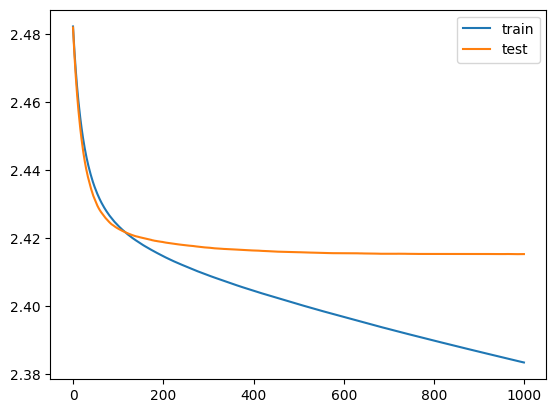

In [10]:
# retrieve performance metrics
# results = clf_gpu.evals_result()
plt.plot(xgb_model.evals_result()['validation_0']['mlogloss'], label='train')
plt.plot(xgb_model.evals_result()['validation_1']['mlogloss'], label='test')
plt.legend()
plt.show()


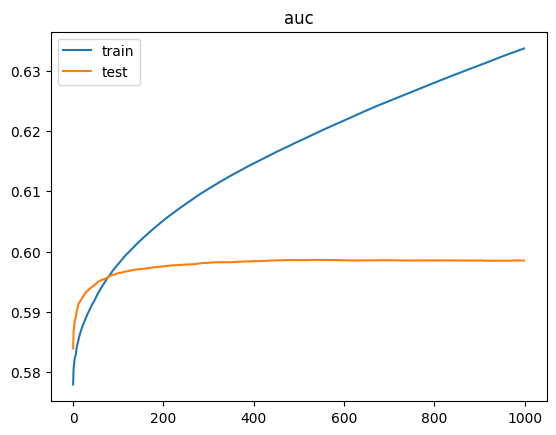

In [11]:
# ['merror', 'auc', 'mlogloss']
plt.plot(xgb_model.evals_result()['validation_0']['auc'], label='train')
plt.plot(xgb_model.evals_result()['validation_1']['auc'], label='test')
plt.title('auc')
plt.legend()
plt.show()
# xgb_model.evals_result()['validation_0'].keys()

<Axes: >

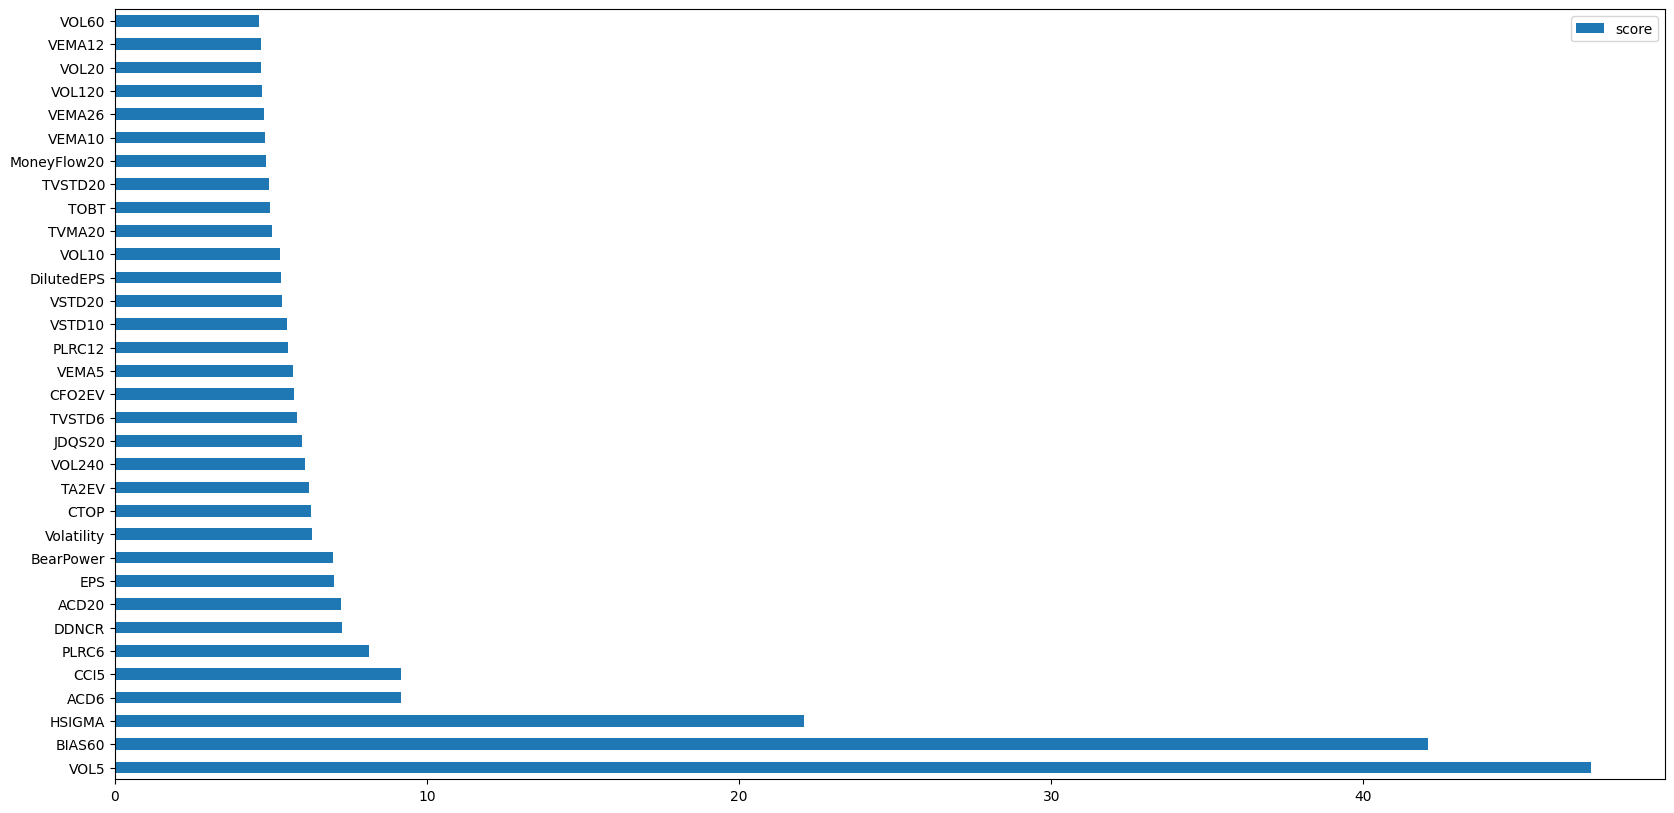

In [12]:
# 特征重要性
feature_important = xgb_model.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

d = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
d.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

### 回测

#### 等权持有概率最高的n_stock支股票

In [8]:
# 样本外预测值
test_data['y_pred'] = xgb_model.get_booster().predict(xgb.DMatrix(X_test)).argmax(1)
test_data['y_prob'] = xgb_model.get_booster().predict(xgb.DMatrix(X_test)).max(1)
test_data

,code,day,sector,weekly_return,VOL60,VOL20,VOL5,VOL10,VOL120,ACD6,...,JDQS20,DDNCR,TVMA20,MoneyFlow20,CTOP,HSIGMA,CCI5,label,y_pred,y_prob
458727,300588,20210226.0,28,7.014680,-0.166624,-0.453745,-0.296233,-0.244678,2.212852,0.567543,...,0.419968,-0.955908,0.655726,0.656432,-0.102067,0.583976,1.958572,1,11,0.114239
458728,603035,20210226.0,13,4.086542,-0.208201,-0.330222,-0.637782,-0.342009,0.152024,0.114476,...,-1.371366,0.365398,-0.055249,-0.054971,1.007634,-0.046324,-0.331149,4,5,0.116646
458729,2838,20210226.0,6,-2.378696,0.318808,-0.218187,-0.483593,-0.476062,-0.036020,0.167201,...,-1.334567,-2.021552,-0.566161,-0.566866,0.536169,1.868589,0.491787,10,8,0.104124
458730,603228,20210226.0,26,3.946459,-1.098036,-1.024061,-0.976244,-0.972639,-1.108704,0.626794,...,0.030079,1.263304,-2.572620,-2.572843,-0.061485,-1.455614,2.084927,4,8,0.131133
458731,603877,20210226.0,17,10.502958,-0.506637,-0.540252,-0.505228,-0.554988,-0.366875,1.543071,...,1.230868,-1.104623,-1.377928,-1.377963,0.205946,1.086508,0.562171,0,11,0.151341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573404,300980,20211022.0,6,1.013339,0.478774,-0.493997,-0.906647,-0.926890,1.402471,-0.310812,...,1.747348,1.026139,0.563466,0.563503,-0.636685,-1.164114,0.013526,3,5,0.139247
573405,605016,20211022.0,6,-1.184309,1.312164,1.556815,0.148629,1.489340,2.500906,-0.562508,...,0.095345,1.555047,0.620462,0.620530,-0.673432,1.574468,-0.828693,4,0,0.091937
573406,605098,20211022.0,15,5.422783,0.612101,1.335030,2.713900,2.722779,2.394376,2.049231,...,0.876572,1.450885,0.623359,0.623791,1.023333,0.898465,1.179519,1,11,0.249347
573407,300975,20211022.0,26,0.603139,1.522815,-0.526855,0.577239,-0.075824,2.010993,0.096832,...,-0.751500,-0.537888,0.031673,0.032428,0.181428,-0.485219,0.870481,3,9,0.100756


In [9]:
# 样本内预测值
train_data['y_pred'] = xgb_model.get_booster().predict(xgb.DMatrix(X_train)).argmax(1)
train_data['y_prob'] = xgb_model.get_booster().predict(xgb.DMatrix(X_train)).max(1)
train_data

,code,day,sector,weekly_return,VOL60,VOL20,VOL5,VOL10,VOL120,ACD6,...,JDQS20,DDNCR,TVMA20,MoneyFlow20,CTOP,HSIGMA,CCI5,label,y_pred,y_prob
0,4,20180105.0,28,-4.024702,-0.775176,-0.917950,-1.061420,-1.222159,-1.161016,0.764560,...,1.940750,-0.199333,-0.268916,-0.268563,-0.397089,-0.441407,0.090599,10,0,0.097791
1,600601,20180105.0,28,-1.355046,-1.246389,-1.201163,-1.220196,-1.228082,-1.201746,-0.507241,...,-1.782799,0.605341,-1.400236,-1.399994,-0.217249,-1.758799,0.140573,6,4,0.150098
2,600652,20180105.0,29,13.520729,-0.744055,-0.683546,-0.724665,-0.672548,-0.431911,-0.313788,...,-0.269848,-0.297214,-0.631245,-0.631016,0.053134,0.010386,0.663940,0,6,0.101372
3,600602,20180105.0,28,-0.277466,-1.286696,-1.117314,-1.102816,-1.186759,-1.254980,0.030110,...,-0.265318,-1.361486,-1.121716,-1.121395,0.481633,-0.360316,0.511521,4,1,0.107145
4,600651,20180105.0,16,1.354170,0.663059,0.009371,-0.151267,0.070555,0.069727,0.066070,...,-0.905105,0.814633,-0.344706,-0.345137,0.192816,0.109807,0.292743,2,5,0.103384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458722,603186,20210226.0,26,13.626062,-0.651357,-1.061031,-0.693287,-0.960933,-0.963230,1.780353,...,0.526518,0.810228,-1.191852,-1.192239,-0.101858,-0.810112,2.545721,0,10,0.126128
458723,300586,20210226.0,6,5.357623,0.918316,-0.508231,-0.631298,-0.731346,0.861473,0.249731,...,-0.172908,-0.947444,0.183726,0.183495,-0.319670,0.769978,-0.610403,2,7,0.103505
458724,603444,20210226.0,29,21.956516,0.538870,0.899281,0.762068,0.709527,0.166477,-2.016481,...,0.067969,-0.622123,1.391392,1.385760,0.665925,0.620379,-0.893500,0,11,0.143517
458725,300587,20210226.0,6,9.776616,-0.004436,0.556107,0.294251,0.194679,-0.133916,0.234807,...,1.138289,-2.247582,0.162679,0.164443,-0.269391,-0.161896,-0.769773,1,8,0.103956


In [10]:
# 获取指数benchmark数据
citi_path = '/home/ubuntu/raw_data/citi_sector_33_info.csv'
Andariel_path = '/home/ubuntu/raw_data/_Andariel_20230426.mat'
# DIABLO_FILE = '/Users/shaorui/Desktop/CMA/Diablo_EVA_20230411.parquet'

def read_Andariel(Andariel_path, citi_path):
    
    ############################# BASIC-info <<<>>> JuYuan by Matlab 
    data_mat    = loadmat(Andariel_path)
    citi_sector = pd.read_csv(citi_path, encoding="gbk")
    jstockcode  = data_mat['Data'][0,0]['jstockcode'].ravel()
    jipoday     = data_mat['Data'][0,0]['jipodate'].ravel()
    jquitday    = data_mat['Data'][0,0]['jquitday'].ravel()
    jstockname  = data_mat['Data'][0,0]['jstockname'].ravel()
    EOM         = np.array(data_mat['Data'][0,0]['date_EOM']).ravel()
    EOW         = np.array(data_mat['Data'][0,0]['date_EOW']).ravel()
    ALLDAYS     = np.array(data_mat['Data'][0,0]['ALLDAY']).ravel()
    ST          = np.asarray(data_mat['Data'][0,0]['ST'])
    Citics1     = np.asarray(data_mat['Data'][0,0]['Citics'])[:,-1]
    CITI        = np.zeros_like(Citics1)
    for i in range(len(CITI)):  #slow
        CITI[i] = citi_sector.loc[citi_sector['code']==Citics1[i]]['id']
    CITI[np.where(CITI==31)]=30
    windforce = pd.DataFrame({'code':jstockcode,'name':jstockname,'ipoday':jipoday,'quitday':jquitday,'citics_sector':Citics1,'sector':CITI})
    
    ZZ500info      = data_mat['GUNDAM'][0,0]['ZZ500info'] 
    ZZ500_DAYS     = [int(i) for i in ZZ500info[0,:]['date']]
    INDEXPRICE_500 = data_mat['GUNDAM'][0,0]['Index_Price_ZZ500']  # day close open
    
    # HS300info  = data_mat['GUNDAM'][0,0]['HS300info'] 
    # HS300_DAYS = [int(i) for i in HS300info[0,:]['date']]
    # INDEXPRICE_300 = data_mat['GUNDAM'][0,0]['Index_Price_HS300']  # day close open

    andariel = {'jstockcode':jstockcode,
                'jipoday':jipoday,
                'jipoday':jipoday,
                'jquitday':jquitday,
                'jstockname':jstockname,
                'EOM':EOM,
                'EOW':EOW,
                'ALLDAYS':ALLDAYS,
                'ST':ST,
                'citi_sector':citi_sector,
                'windforce':windforce,
                'ZZ500info':ZZ500info,
                'ZZ500_DAYS':ZZ500_DAYS,
                'INDEXPRICE_500':INDEXPRICE_500 # [day, close, open]
                }
    return andariel

andariel = read_Andariel(Andariel_path, citi_path)
zz500_price = pd.DataFrame(andariel['INDEXPRICE_500'], columns=['day','close','open'])

,持有股票数,总周数,盈利周数,亏损周数,胜率
0,20.0,35.0,18.0,17.0,0.514286
1,30.0,35.0,18.0,17.0,0.514286
2,50.0,35.0,22.0,13.0,0.628571
3,80.0,35.0,23.0,12.0,0.657143
4,100.0,35.0,23.0,12.0,0.657143
5,130.0,35.0,23.0,12.0,0.657143


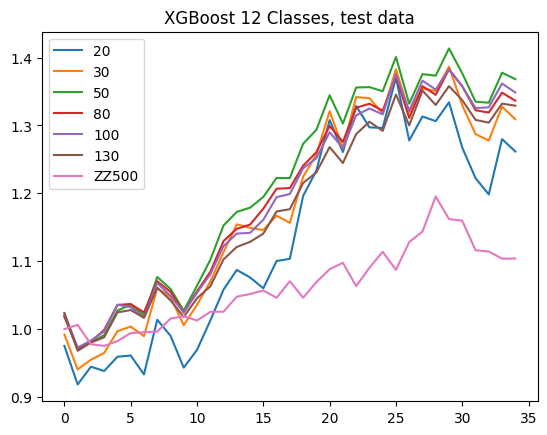

In [20]:
# 样本外回测
win_lose_df = pd.DataFrame(columns=['持有股票数','总周数','盈利周数','亏损周数','胜率'])
for n_stock in [20, 30, 50, 80, 100,130]:
# for n_stock in [20, 100,130]:
    # 记录胜率
    a=test_data[(test_data.y_pred==0)].groupby('day').apply(lambda x: (x.sort_values('y_prob',ascending=False)[:n_stock]['weekly_return'].mean()))
    temp = pd.DataFrame.from_dict({'持有股票数':n_stock,'总周数':len(a.values),'盈利周数':sum(a.values>0),'亏损周数': sum(a.values<0),'胜率':sum(a.values>0) / len(a)},orient='index').T
    win_lose_df = pd.concat((win_lose_df, temp),ignore_index=True)
    # 画图
    plt.plot((a.values/100).cumsum()+1, label=n_stock)
zz500_close_test = zz500_price[(zz500_price.day.isin(test_data.day))]['close']
plt.plot(range(len(zz500_close_test)), zz500_close_test/zz500_close_test.iloc[0],label='ZZ500')
plt.legend()
plt.title('XGBoost 12 Classes, test data')

win_lose_df


,持有股票数,总周数,盈利周数,亏损周数,胜率
0,20.0,162.0,113.0,49.0,0.697531
1,30.0,162.0,112.0,50.0,0.691358
2,50.0,162.0,108.0,54.0,0.666667
3,80.0,162.0,106.0,56.0,0.654321
4,100.0,162.0,109.0,53.0,0.672840
5,130.0,162.0,106.0,56.0,0.654321


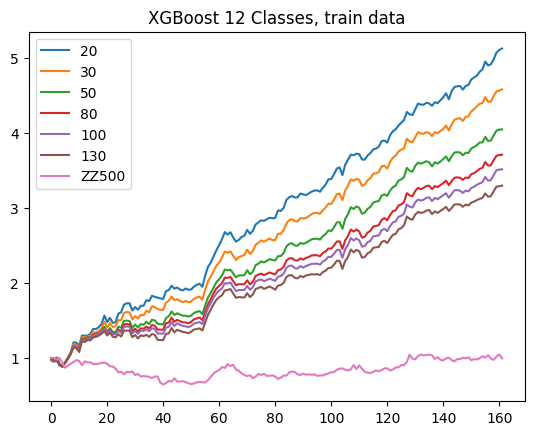

In [21]:
# 样本内回测
win_lose_df = pd.DataFrame(columns=['持有股票数','总周数','盈利周数','亏损周数','胜率'])
for n_stock in [20, 30, 50, 80, 100,130]:
# for n_stock in [20, 100,130]:
    # 记录胜率
    a=train_data[(train_data.y_pred==0)].groupby('day').apply(lambda x: (x.sort_values('y_prob',ascending=False)[:n_stock]['weekly_return'].mean()))
    temp = pd.DataFrame.from_dict({'持有股票数':n_stock,'总周数':len(a.values),'盈利周数':sum(a.values>0),'亏损周数': sum(a.values<0),'胜率':sum(a.values>0) / len(a)},orient='index').T
    win_lose_df = pd.concat((win_lose_df, temp),ignore_index=True)
    # 画图
    plt.plot((a.values/100).cumsum()+1, label=n_stock)
zz500_close_train = zz500_price[(zz500_price.day.isin(train_data.day))]['close']
plt.plot(range(len(zz500_close_train)), zz500_close_train/zz500_close_train.iloc[0],label='ZZ500')
plt.legend()
plt.title('XGBoost 12 Classes, train data')

win_lose_df


### 按zz500行业市值权重选股

每个调仓日，算出该月zz500各个行业的权重，根据该权重配置模型打分最高的股票（目前设置最少持有3支，最多持有7支）

In [205]:
# 计算ZZ500每月的行业权重
def get_ZZ500_sector_proportion(andariel): # {day: {sector: xx%}}
    ZZ500_sector_proportion = {}
    for d, info in tqdm(andariel['ZZ500info'][0]):
        day = d[0,0]
        sector_weight = dict([[i,0] for i in range(1,32)])
        for code, _, weight in info:
            sector = andariel['windforce'][andariel['windforce'].code==code]['sector'].values[0]
            sector_weight[sector] += weight
        ZZ500_sector_proportion[day] = sector_weight
    return ZZ500_sector_proportion

ZZ500_sector_proportion = get_ZZ500_sector_proportion(andariel)


100%|██████████| 159/159 [00:26<00:00,  5.90it/s]


In [12]:
# 计算某一交易日ZZ500的行业权重
def get_sector_proportion(ZZ500_sector_proportion, day):
    ZZ500_days = np.array(list(ZZ500_sector_proportion.keys()))
    ZZ500_day = ZZ500_days[np.where(ZZ500_days<=day)][-1]
    return ZZ500_sector_proportion[ZZ500_day] # {sector: weight}

# 计算每个行业计划购买的股票数量: 按权重等比例购买，设置最小值和最大值
def get_sector_stock_num(sector_proportion, total_num, min_num, max_num):
    stock_num = dict([[i,0] for i in range(1,32)])
    for sector in sector_proportion:
        temp = int(total_num * sector_proportion[sector])
        if temp < min_num:
            stock_num[sector] = min_num
        elif temp > max_num:
            stock_num[sector] = max_num
        else:
            stock_num[sector] = temp
    return stock_num # {stock: n}




In [96]:
def cal_weight(x, sector_proportion, sector_stock_num):
    proportion = sector_proportion[x.sector_temp.values[0]]
    stock_num = x.code.count()
    x['weight'] = proportion / stock_num
    return x

def get_stock_to_buy(sorted_test_return, sector_proportion, sector_stock_num, day):
    # sorted_test_return = test_data.groupby(['day','sector']).apply(lambda x: x.sort_values(['y_pred','y_prob'],ascending=[True, False])[['code','y_pred','y_prob','weekly_return']])
    temp = sorted_test_return[sorted_test_return.index.get_level_values('day') == day].copy()
    temp['sector_temp'] = temp.index.get_level_values('sector')
    temp = temp.groupby(level=1).apply(lambda x: x[:sector_stock_num[x.sector_temp.values[0]]])
    temp = temp.droplevel(0)
    temp = temp.groupby('sector').apply(lambda x: cal_weight(x, sector_proportion, sector_stock_num))
    temp = temp.droplevel(0)
    temp.drop('sector_temp', axis=1,inplace=True)
    return temp


In [107]:
# 获取每个交易日购买的股票及其权重
sorted_test_return = test_data.groupby(['day','sector']).apply(lambda x: x.sort_values(['y_pred','y_prob'],ascending=[True, False])[['code','y_pred','y_prob','weekly_return']])
total_num = 130
min_num, max_num = 3, 7
stock_to_buy = pd.DataFrame()
for day in test_data.day.unique():
    sector_proportion = get_sector_proportion(ZZ500_sector_proportion, day) # {sector: xx%}
    sector_stock_num = get_sector_stock_num(sector_proportion, total_num, min_num, max_num)
    day_stock_to_buy = get_stock_to_buy(sorted_test_return, sector_proportion, sector_stock_num, day)
    day_stock_to_buy = day_stock_to_buy.reset_index().drop('level_2',axis=1)
    stock_to_buy = pd.concat([stock_to_buy, day_stock_to_buy], ignore_index=True)

stock_to_buy


100%|██████████| 35/35 [00:01<00:00, 29.29it/s]


,day,sector,code,y_pred,y_prob,weekly_return,weight
0,20210226.0,1,603225,0,0.149786,-6.152320,0.006193
1,20210226.0,1,300876,0,0.112204,2.189350,0.006193
2,20210226.0,1,300839,0,0.107843,20.059633,0.006193
3,20210226.0,2,603113,11,0.156564,7.342494,0.009940
4,20210226.0,3,300618,0,0.218086,-11.393124,0.008640
...,...,...,...,...,...,...,...
4361,20211022.0,29,300418,1,0.113255,7.295835,0.008462
4362,20211022.0,29,300770,1,0.106037,1.884139,0.008462
4363,20211022.0,30,688516,0,0.204944,4.999995,0.007313
4364,20211022.0,30,688116,0,0.202236,9.068727,0.007313


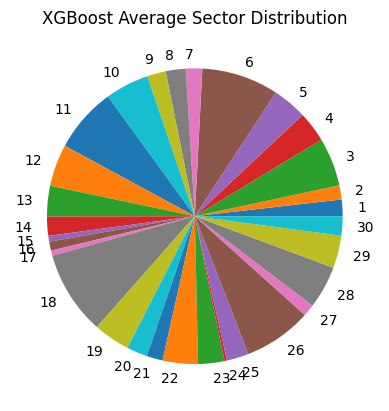

In [144]:
# XGBoost
plt.pie(stock_to_buy.sort_values('sector',ascending=True).groupby('sector').weight.sum(), labels=range(1,31))
plt.title("XGBoost Average Sector Distribution") # 设置标题
plt.show()

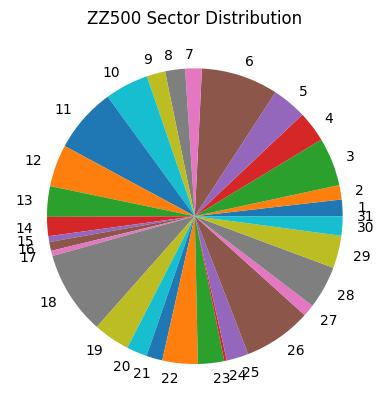

In [198]:
# ZZ500
t=pd.DataFrame(ZZ500_sector_proportion).T.reset_index()
plt.pie(t[(t['index'] >= test_data.day.min()) & (t['index'] <= test_data.day.max())].drop('index',axis=1).T.mean(axis=1), labels=range(1,32))
plt.title("ZZ500 Sector Distribution") # 设置标题
plt.show()


,平均持有股票数,总周数,盈利周数,亏损周数,胜率
1,124.742857,35.0,22.0,13.0,0.628571


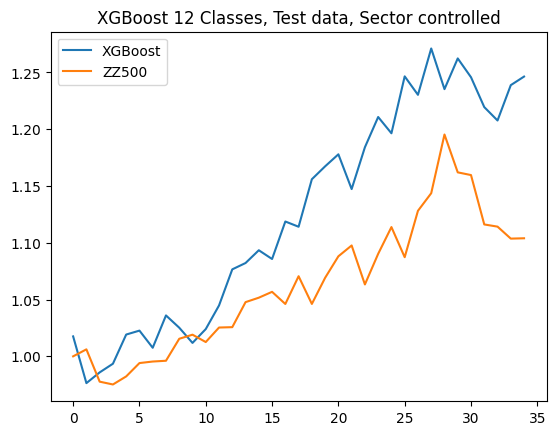

In [207]:
# 测试test set
win_lose_df = pd.DataFrame(columns=['平均持有股票数','总周数','盈利周数','亏损周数','胜率'])
a1 = stock_to_buy.groupby('day').code.count().mean()
a2 = len(stock_to_buy.groupby('day').groups)
payoff = stock_to_buy.groupby('day').apply(lambda x: (x['weight'] * x['weekly_return']).sum())
a3 = np.sum(payoff > 0)
a4 = np.sum(payoff < 0)
a5 = a3/a2
win_lose_df.loc[1] = [a1, a2, a3, a4, a5]

plt.plot((payoff.values/100).cumsum()+1, label='XGBoost')
zz500_close_test = zz500_price[(zz500_price.day.isin(test_data.day))]['close']
plt.plot(range(len(zz500_close_test)), zz500_close_test/zz500_close_test.iloc[0],label='ZZ500')
plt.legend()
plt.title('XGBoost 12 Classes, Test data, Sector controlled')

win_lose_df


Text(0.5, 1.0, 'Alpha')

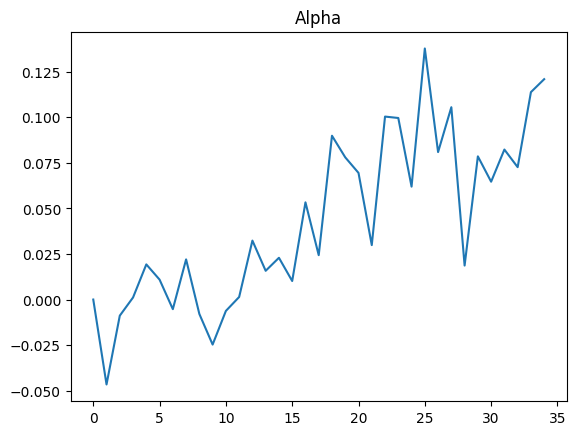

In [239]:
# 浅画一个超额收益
xgboost_payoff = stock_to_buy.groupby('day').apply(lambda x: (x['weight'] * x['weekly_return']).sum())
xgboost_accum = (xgboost_payoff.values/100).cumsum() + 1
xgboost_accum = xgboost_accum/xgboost_accum[0]
zz500_close_test = zz500_price[(zz500_price.day.isin(test_data.day))]['close']
zz500_accum = zz500_close_test/zz500_close_test.iloc[0]

plt.plot(xgboost_accum -zz500_accum.values)
plt.title('Alpha')

In [200]:
# 训练集
sorted_train_return = train_data.groupby(['day','sector']).apply(lambda x: x.sort_values(['y_pred','y_prob'],ascending=[True, False])[['code','y_pred','y_prob','weekly_return']])
total_num = 130
min_num, max_num = 3, 7
train_stock_to_buy = pd.DataFrame()
for day in train_data.day.unique():
    sector_proportion = get_sector_proportion(ZZ500_sector_proportion, day) # {sector: xx%}
    sector_stock_num = get_sector_stock_num(sector_proportion, total_num, min_num, max_num)
    day_stock_to_buy = get_stock_to_buy(sorted_train_return, sector_proportion, sector_stock_num, day)
    day_stock_to_buy = day_stock_to_buy.reset_index().drop('level_2',axis=1)
    train_stock_to_buy = pd.concat([train_stock_to_buy, day_stock_to_buy], ignore_index=True)

train_stock_to_buy

100%|██████████| 162/162 [00:05<00:00, 29.86it/s]


,day,sector,code,y_pred,y_prob,weekly_return,weight
0,20180105.0,1,985,0,0.099257,-3.293145,0.006437
1,20180105.0,1,698,1,0.094425,-2.731657,0.006437
2,20180105.0,1,600339,2,0.102433,-0.335568,0.006437
3,20180105.0,2,600188,0,0.150068,2.574492,0.004770
4,20180105.0,2,600997,0,0.113176,0.130498,0.004770
...,...,...,...,...,...,...,...
20525,20210226.0,29,300280,0,0.107048,21.594524,0.009187
20526,20210226.0,29,300413,1,0.133417,1.053572,0.009187
20527,20210226.0,30,300526,0,0.193833,1.352024,0.006000
20528,20210226.0,30,600532,0,0.134262,0.398290,0.006000


,平均持有股票数,总周数,盈利周数,亏损周数,胜率
1,126.728395,162.0,102.0,60.0,0.62963


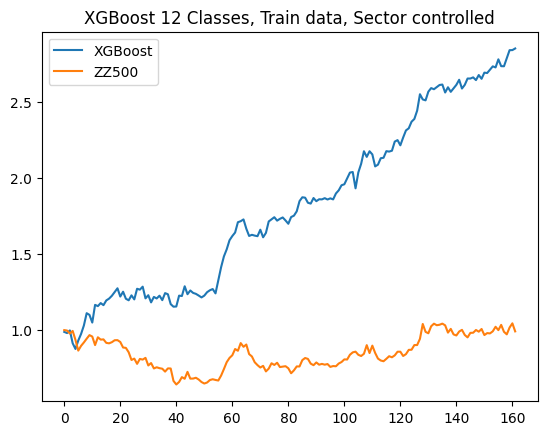

In [203]:
# 测试训练集
win_lose_df = pd.DataFrame(columns=['平均持有股票数','总周数','盈利周数','亏损周数','胜率'])
a1 = train_stock_to_buy.groupby('day').code.count().mean()
a2 = len(train_stock_to_buy.groupby('day').groups)
payoff = train_stock_to_buy.groupby('day').apply(lambda x: (x['weight'] * x['weekly_return']).sum())
a3 = np.sum(payoff > 0)
a4 = np.sum(payoff < 0)
a5 = a3/a2
win_lose_df.loc[1] = [a1, a2, a3, a4, a5]

plt.plot((payoff.values/100).cumsum()+1, label='XGBoost')
zz500_close_train = zz500_price[(zz500_price.day.isin(train_data.day))]['close']
plt.plot(range(len(zz500_close_train)), zz500_close_train/zz500_close_train.iloc[0],label='ZZ500')
plt.legend()
plt.title('XGBoost 12 Classes, Train data, Sector controlled')

win_lose_df

In [129]:
t

day
20210226.0    1.755893
20210305.0   -4.116120
20210312.0    0.945856
20210319.0    0.763910
20210326.0    2.568892
20210402.0    0.346507
20210409.0   -1.510914
20210416.0    2.847752
20210423.0   -1.079654
20210430.0   -1.340211
20210507.0    1.219866
20210514.0    2.078060
20210521.0    3.180926
20210528.0    0.557649
20210604.0    1.124667
20210611.0   -0.771394
20210618.0    3.302987
20210625.0   -0.462067
20210702.0    4.184608
20210709.0    1.135830
20210716.0    1.059248
20210723.0   -3.061567
20210730.0    3.682975
20210806.0    2.663874
20210813.0   -1.433064
20210820.0    5.013008
20210827.0   -1.626456
20210903.0    4.082216
20210910.0   -3.581133
20210917.0    2.705408
20210924.0   -1.657541
20210930.0   -2.629868
20211008.0   -1.179517
20211015.0    3.113886
20211022.0    0.754563
dtype: float64

## XGBoost 回归 （Todo)

## 线性回归 (Todo)